In [1]:
import tensorflow as tf
from tensorflow.keras import backend
import tensorflow_datasets as tfds
import PIL

dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

2023-04-20 10:50:34.918820: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-20 10:50:34.919959: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-20 10:50:34.942306: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-20 10:50:34.942882: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 10:50:35.394081: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

## Transformer for semantic segmentation (Segmenter) 

1. Create conda environment 
2. Install neccessary packages: tensorflow, matplotlib, pynvml 
3. Train Segmenter using custom data

Helpful links: 

[How to train SegFormer](https://keras.io/examples/vision/segformer/)  
[How to fine-tune SegFormer using just one GPU](https://huggingface.co/docs/transformers/perf_train_gpu_one)   
[How to train SegFormer using Custom data]()  


### [TrashCan dataset](https://conservancy.umn.edu/handle/11299/214865) 

[Coco for semantic segmentation](https://conservancy.umn.edu/handle/11299/214865)


In [2]:
from pynvml import *
%env SM_FRAMEWORK=tf.keras


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

env: SM_FRAMEWORK=tf.keras


In [3]:
image_size = 512
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.224])

def normalize(input_image, input_mask):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    input_mask -= 1
    return input_image, input_mask

def load_image(datapoint): 
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"], 
        (image_size, image_size), 
        method="bilinear", 
    )
    
    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))
    return{"pixel_values": input_image, "labels": tf.squeeze(input_mask)}
            


In [4]:
auto = tf.data.AUTOTUNE
batch_size = 64

train_ds = (
    dataset["train"]
    .cache()
    .shuffle(batch_size * 10)
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)

test_ds = (
    dataset["test"]
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)


In [5]:
print(train_ds.element_spec)

{'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.float32, name=None)}


2023-04-20 10:50:36.595986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype float and shape [3]
	 [[{{node Placeholder/_27}}]]
2023-04-20 10:50:36.596237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [4]
	 [[{{node Placeholder/_4}}]]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


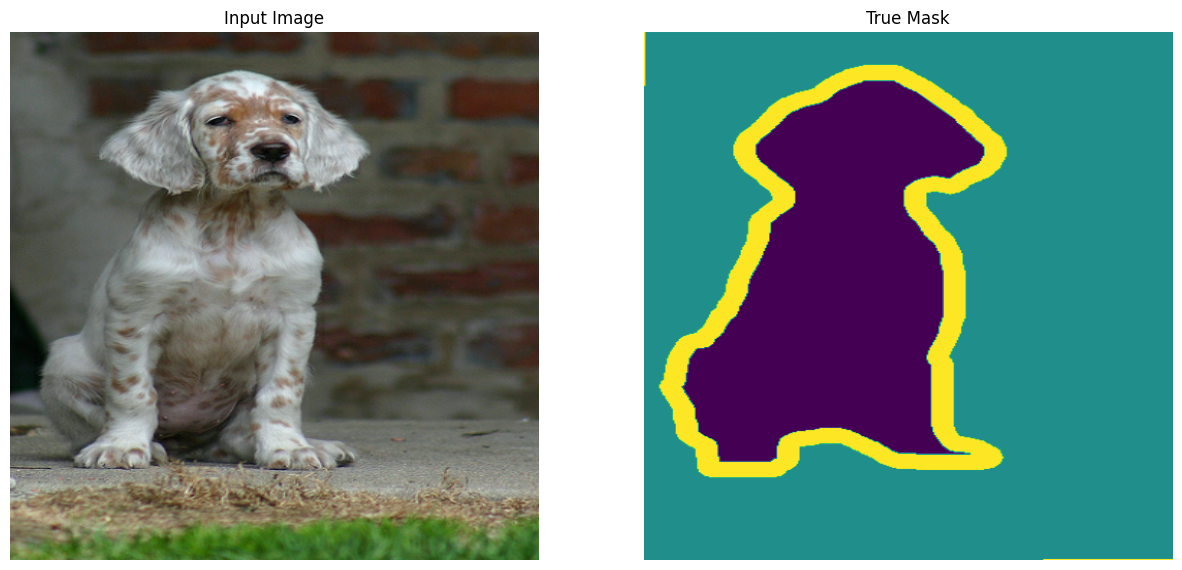

2023-04-20 10:50:37.335989: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


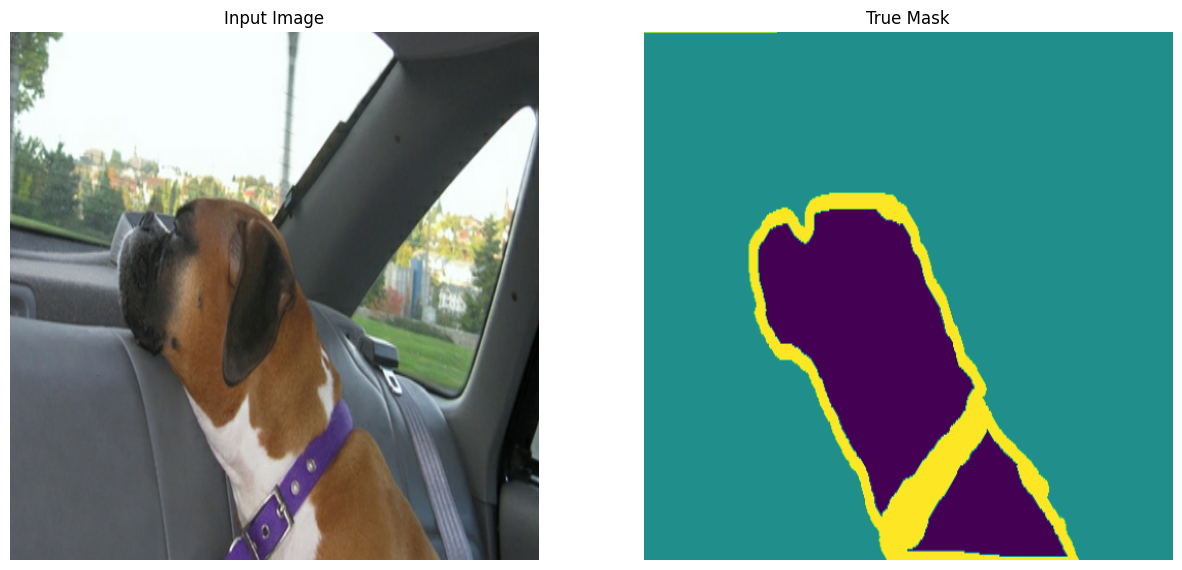

In [6]:
import matplotlib.pyplot as plt

def display(display_list): 
    plt.figure(figsize=(15, 15))
    
    title = ["Input Image", "True Mask", "Predicted Mask"]
    
    for i in range(len(display_list)): 
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()
    
for samples in train_ds.take(2): 
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    display([sample_image, sample_mask])

In [7]:
from transformers import TFSegformerForSemanticSegmentation 
from transformers import SegformerModel

model_checkpoint = "nvidia/mit-b0"
id2label = {0: "outer", 1:"inner", 2:"border"}
label2id = {label: id for id, label in id2label.items()}

num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint, 
    num_labels=num_labels, 
    id2label=id2label, 
    label2id=label2id, 
    ignore_mismatched_sizes=True,)

2023-04-20 10:50:38.200323: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x8f8f900 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-04-20 10:50:38.200338: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Host, Default Version
2023-04-20 10:50:38.205171: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
lr = 0.00006 
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [9]:
from IPython.display import clear_output

def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], masks[0], create_mask(pred_masks)])
    else:
        display(
            [
                sample_image, 
                sample_mask, 
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )
        
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset
        
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))
        

2023-04-20 14:42:40.832950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype float and shape [3]
	 [[{{node Placeholder/_19}}]]
2023-04-20 14:42:40.833196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype float and shape [3]
	 [[{{node Placeholder/_20}}]]


2/2 [==============================] - 15s 7s/step


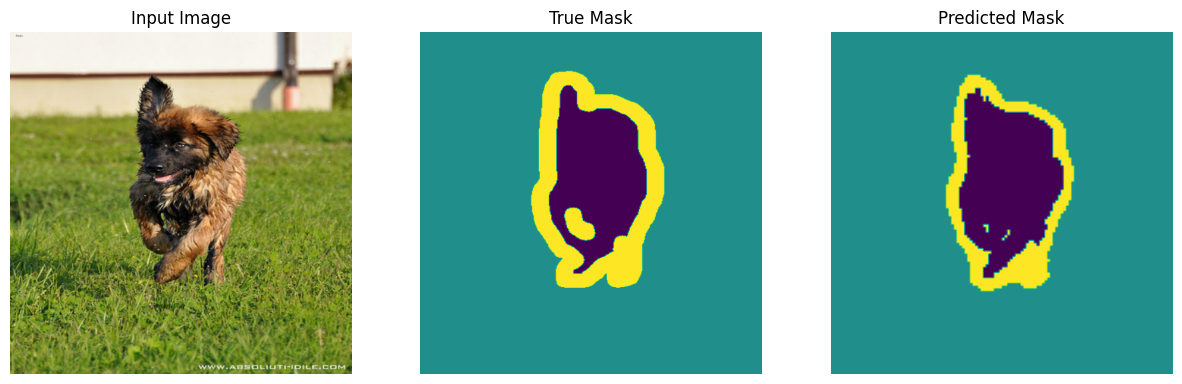


Sample Prediction after epoch 5

58/58 [==============================] - 2787s 48s/step - loss: 0.2031 - val_loss: 0.2140


In [10]:
# Increase the number of epochs if the results are not of expected quality
epochs_ = 5

history = model.fit(
    train_ds, 
    validation_data=test_ds, 
    callbacks=[DisplayCallback(test_ds)], 
    epochs=epochs_,
)

In [13]:
#print(tf.__version__)
print(dataset)


{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>, 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}


In [15]:
from PIL import Image
import os

# Define the folder path
folder_path = "./dataset/original_data/images"

# Get a list of all image files in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]

# Open and show the first 10 images in the folder
for i in range(10):
    if i < len(image_files):
        image = Image.open(image_files[i])
        image.show()
    else:
        break


(eog:226935): EOG-CRITICAL **: 11:11:37.032: eog_image_get_file: assertion 'EOG_IS_IMAGE (img)' failed

(eog:226935): GLib-GIO-CRITICAL **: 11:11:37.032: g_file_equal: assertion 'G_IS_FILE (file1)' failed

(eog:226935): EOG-CRITICAL **: 11:11:37.032: eog_image_get_file: assertion 'EOG_IS_IMAGE (img)' failed

(eog:226935): GLib-GIO-CRITICAL **: 11:11:37.032: g_file_equal: assertion 'G_IS_FILE (file1)' failed

(eog:226935): EOG-CRITICAL **: 11:11:37.032: eog_image_get_file: assertion 'EOG_IS_IMAGE (img)' failed

(eog:226935): GLib-GIO-CRITICAL **: 11:11:37.032: g_file_equal: assertion 'G_IS_FILE (file1)' failed

(eog:226935): EOG-CRITICAL **: 11:11:37.046: eog_image_get_file: assertion 'EOG_IS_IMAGE (img)' failed

(eog:226935): GLib-GIO-CRITICAL **: 11:11:37.046: g_file_equal: assertion 'G_IS_FILE (file1)' failed

(eog:226935): EOG-CRITICAL **: 11:11:37.046: eog_image_get_file: assertion 'EOG_IS_IMAGE (img)' failed

(eog:226935): GLib-GIO-CRITICAL **: 11:11:37.046: g_file_equal: asserti